### <b>Table of Content</b>

0. Import functions

1. Load data

2. Exploratory data analysis (EDA)

3.

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [1]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, seasonal_decomposition, add_features_from_previous_dates
from utils.plot import plot_histograms, plot_heatmap, plot_autocorrelation
from utils.predict import get_trading_decision_and_results

import warnings
warnings.simplefilter('ignore', UserWarning)

### <b>1. Load data</b>

In [2]:
# Assign details of the source file in G Drive to local variables.
base_url = 'https://drive.google.com/file/d/'
file_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
file_url = f'{base_url}{file_id}'
file_name = '2020Q1Q2Q3Q4-2021Q1.xlsx'

# Assign details of local directories to local variables.
root_dir = sys.path[0]
download_dir = Path(root_dir) / 'data'
file_path = download_dir / file_name

# Download the file if it's not found in the file path.
if os.path.exists(file_path):
    print(f'File {file_name} already exists in {download_dir}.')
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f'File {file_name} is not found in {download_dir}.')
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

# Move back to the root directory.
if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in d:\OneDrive\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [3]:
full_sheet_names = [
    'Russia - Sberbank Rossii PAO (SBER)',
    'Turkey - Koc Holding AS (KCHOL)',
    'Egypt - Medinet Nasr Housing (MNHD)',
    'Brazil - Minerva SA/Brazil (BEEF3)',
    'Argentina - Pampa Energia SA (PAMP)',
    'Colombia - Cementos Argos SA (CCB)',
    'South Africa - Impala Platinum Holdings Ltd (IMPJ)',
    'South Korea - Dongkuk Steel Mill Co Ltd (001230)'
]
data_dfs = load_dataframes(file_path, full_sheet_names)

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


### <b>2. Exploratory data analysis (EDA)</b>

#### 2-1. Examine the format and perform basic data manipulation

We have loaded 8 DataFrames (for 8 different stocks) but the format of each of the DataFrames should be the same.<br>
Have a look at the first one.

In [4]:
first_df = data_dfs[full_sheet_names[0]]
print('Basic info of the first DateFrame:\n')
print(first_df.info())
print('\n')
print('Tail of the first DataFrame:\n')
print(first_df.tail())

Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Tail of the first DataFrame:

          Date   Price    Open    High     Low    Vol.  Change %
306 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
307 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
308 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
309 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
310 2020-01-

- Since we have time-series data, set the 'Date' column as index.
- The dtype of the 'Vol.' column is object, which needs to be converted to either integer or float so that the values are machine-readable, in other words so that they can be used as a training feature.
- Additionally, the 'Price' column will be the target to be predicted, which is the closing price for each trading date.

In [5]:
df = first_df.set_index('Date').sort_index()
df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071


#### 2-2. Plot histograms and box plots to understand the distribution of each column

Distribution of target 'Price' and dependent variables:


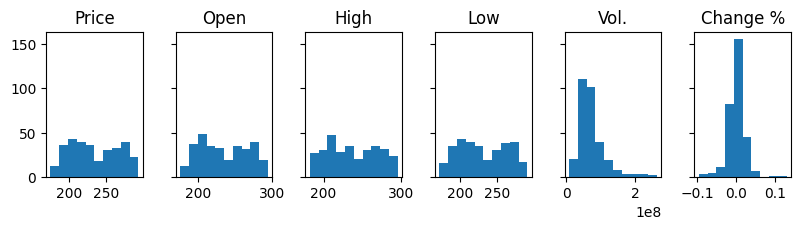

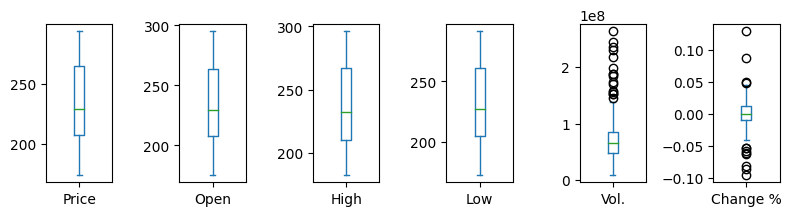

In [6]:
plot_histograms(data=df,
                target='Price', target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

- The 'Vol.' column is right-skewed.
- The 'Change %' column is roughly normally distributed.
- The 'Vol.' and 'Change %' columns have many outliers. 
- The other columns show bimodal distributions without outliers.

#### 2-3. Plot a correlation heatmap and analyze correlations between the target and other columns

,Price,Open,High,Low,Vol.,Change %
Price,1.000000,0.992246,0.996541,0.995765,-0.245279,0.089939
Open,0.992246,1.000000,0.996392,0.996370,-0.262197,-0.014046
High,0.996541,0.996392,1.000000,0.994497,-0.215092,0.034574
Low,0.995765,0.996370,0.994497,1.000000,-0.291138,0.037396
Vol.,-0.245279,-0.262197,-0.215092,-0.291138,1.000000,0.044594
Change %,0.089939,-0.014046,0.034574,0.037396,0.044594,1.000000


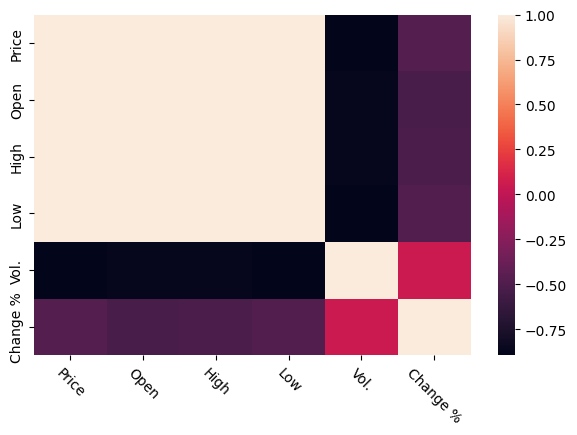

In [7]:
plot_heatmap(df.corr(), figsize=(6, 4), rotate_xticks=-45)
df.corr()

- The correlation between the 'Change %' and the target (i.e. 'Price') column is very low - less than 0.1.
- The correlation between the 'Vol.' and 'Price' columns is also pretty low - the absolute value of it is less than 0.3.
- Thus, these two columns would not be useful in training a predictive model.

#### 2-4. Perform STL (Seasonal and Trend decomposition using LOESS) to identify seasonalities in the data

STL is a versatile and robust method for decomposing time series.<br>
LOESS (Locally Estimated Scatterplot Smoothing) is a nonparametric method, where no assumptions are made about the underlying structure of a series of data, for estimating nonlinear relationships. It uses local regression to fit a smooth curve through a scatterplot of data.

Although STL can capture general patterns without assuming data, it does not automatically handle trading day or calendar variation, and it only provides facilities for additive decompositions.

Plotting seasonal componets:


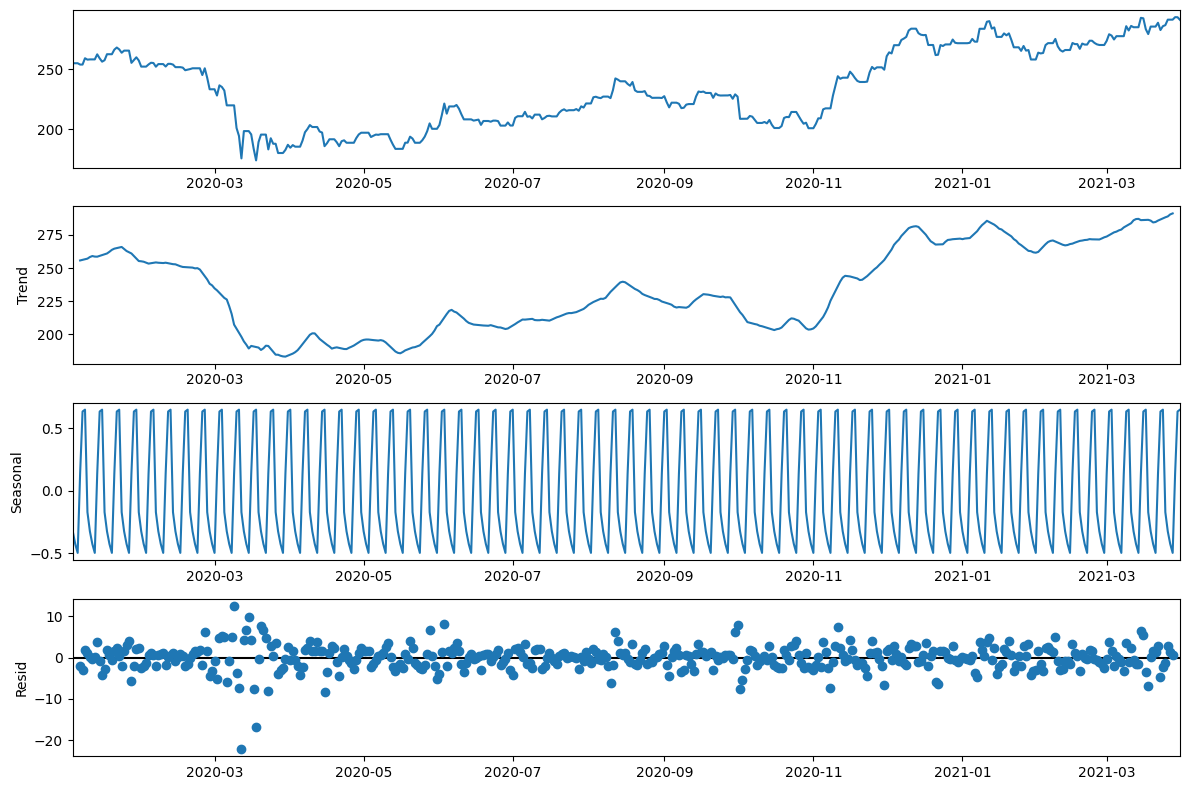

In [8]:
seasonal_decomposition(df=df, frequency='D', column='Price', add_to_df=False, plot=True)

- The original data and the Trend component (i.e. the first and second plots) look very similar, indicating seasonality in the time series data is not significant.

very regular movements in the Seasonal plot

most of the residuals (i.e. the Resid plot) are centered around 0

#### 2-5. Plot auto correlation and partial autocorrelation

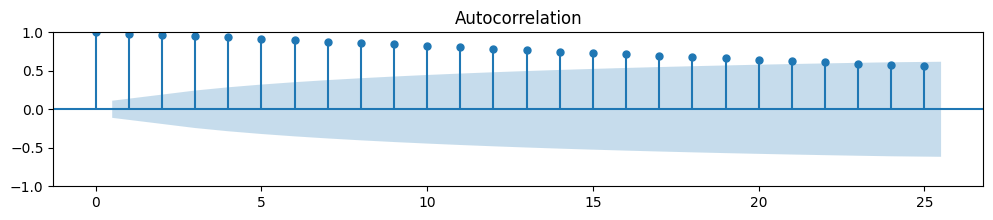

In [9]:
plot_autocorrelation(df, 'Price', partial=False)

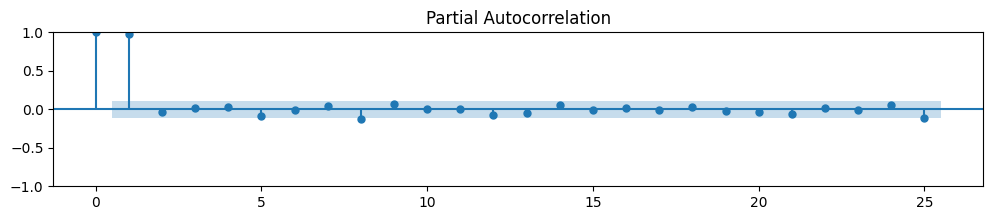

In [10]:
plot_autocorrelation(df, 'Price', partial=True)

interpretation of the plots:

The next day (i.e. where the X value in the plot is 1) has an autocorrelation of almost 1, meaning only the previous day would be relevant to today. To put it differently, most past data except for yesterday's data may not be helpful in predicting today's data, in our case today's closing price (i.e. the 'Price' column).




----------------------------------------------
- 3-4. PACF: the autocorrelation function

The PACF is an alternative to the ACF. Rather than giving the autocorrelations, it gives you the partial autocorrelation. This autocorrelation is called partial, because with each step back in the past, only additional autocorrelation is listed. This is different from the ACF, as the ACF contains duplicate correlations when variability can be explained by multiple points in time.

you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

There's little autocorrelation after the first two dates, meaning only the next date would be highly correlated with each date in the timeseries data, which makes sense for stock market price data.

### <b>3. feature selection and engineering</b>

possible features to use:
- on average has the price gone up or donw in the last week?
- what is the change over the last 2 days (prices on day-1 vs. day-2), last 3 days, 4 days, or a week?
- this is to get model learns/captures the price movement in the recent past.


* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.

1. 'Vol.' and 'Change %' are not relevant based on correlation coefficeints with the target column 'Price', hence drop them.
2. Only the previous date's price is highly correlated with today's price based on auto correlation, thus don't look too further in the past.

In [11]:
concat_df = add_features_from_previous_dates(df, min_previous_date=2, max_previous_date=8)

# Drop the target column and the columns that will not be available when making predictions
X = concat_df.drop(['Price', 'Open', 'High', 'Low'], axis=1)
print("Training features:")
print(*list(X.columns), sep='\n')

y = concat_df['Price']
print("\nTarget: Price")

Training features:
Price (Day-1)
Open (Day-1)
High (Day-1)
Low (Day-1)
2 Day SMA (Day-1)
3 Day SMA (Day-1)
4 Day SMA (Day-1)
5 Day SMA (Day-1)
6 Day SMA (Day-1)
7 Day SMA (Day-1)
2 Day Max High (Day-1)
3 Day Max High (Day-1)
4 Day Max High (Day-1)
5 Day Max High (Day-1)
6 Day Max High (Day-1)
7 Day Max High (Day-1)
2 Day Min Low (Day-1)
3 Day Min Low (Day-1)
4 Day Min Low (Day-1)
5 Day Min Low (Day-1)
6 Day Min Low (Day-1)
7 Day Min Low (Day-1)

Target: Price


### <b>4. train models</b>

train-test split

In [26]:
X_train = X[X.index.year == 2020]
X_test = X[X.index.year == 2021]

y_train = y[y.index.year == 2020]
y_test = y[y.index.year == 2021]

train a SARIMAX model

In [27]:
# https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                    exogenous= X_train,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
step_wise.summary()

# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464.557, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1461.760, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1463.283, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1463.233, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1459.800, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.436 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -728.900
Date:                Sat, 15 Jul 2023   AIC                           1459.800
Time:                        19:57:39   BIC                           1463.289
Sample:                             0   HQIC                          1461.206
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.1937      1.313     18.428      0.000      21.620      26.767
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               134.83
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  243
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -700.893
Date:                Sat, 15 Jul 2023   AIC                           1447.786
Time:                        19:57:40   BIC                           1528.031
Sample:                             0   HQIC                          1480.112
                                - 243                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Price (Day-1)              0.0346      0.173      0.199      0.842      -0.305       0.374
Open (Day-1)              -0.2050      0.154     -1.328      0.184      -0.508       0.097
High

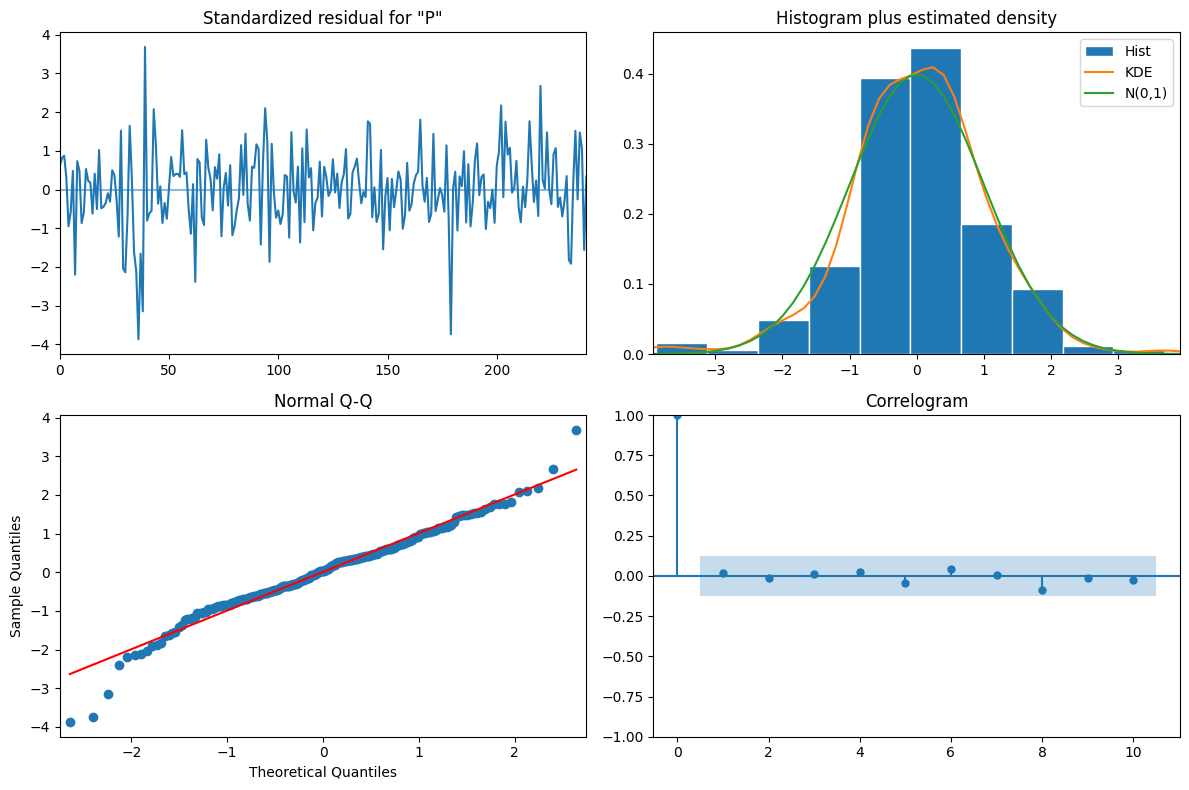

In [28]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

sarimax_model = SARIMAX(
    endog = y_train,
    exog = X_train,
    order=(0, 1, 0),
    # seasonal_order=(0,1,0,7) => not relevant/required since seasonality is not present in the data.
    )
results = sarimax_model.fit(disp=False)
print(results.summary())

results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method above produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
3. Normal Q-Q plot, with Normal reference line.
4. Correlogram

train a random forest regressor and xgb regressor and compare performance of different models
=> SARIMAX seems to perform the best.

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

pred = results.get_prediction(start=X_train.shape[0],
                              end=X_train.shape[0] + X_test.shape[0] - 1,
                              exog=X_test)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean
pred_mean.index = X_test.index
print(f'''SARIMAX model:
Mean Squared Error: {mean_squared_error(y_test, pred_mean)}
R2 Score: {r2_score(y_test, pred_mean)}
''')

# Train non-timeseries regression models
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=2, random_state=5)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)
print(f'''RandomForestRegressor:
Mean Squared Error: {mean_squared_error(y_test, rf_pred)}
R2 Score: {r2_score(y_test, rf_pred)}
''')

from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=5)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
print(f'''XGBRegressor:
Mean Squared Error: {mean_squared_error(y_test, xgb_pred)}
R2 Score: {r2_score(y_test, xgb_pred)}
''')

SARIMAX model:
Mean Squared Error: 69.79506367181196
R2 Score: 0.15625030373368698

RandomForestRegressor:
Mean Squared Error: 168.69755519010013
R2 Score: -1.039377908182963

XGBRegressor:
Mean Squared Error: 90.31680472847955
R2 Score: -0.09183619225173456



#### 5. Create Bollinger Bands and compare it with the SARIMAX predictions to make trading decisions.

* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.

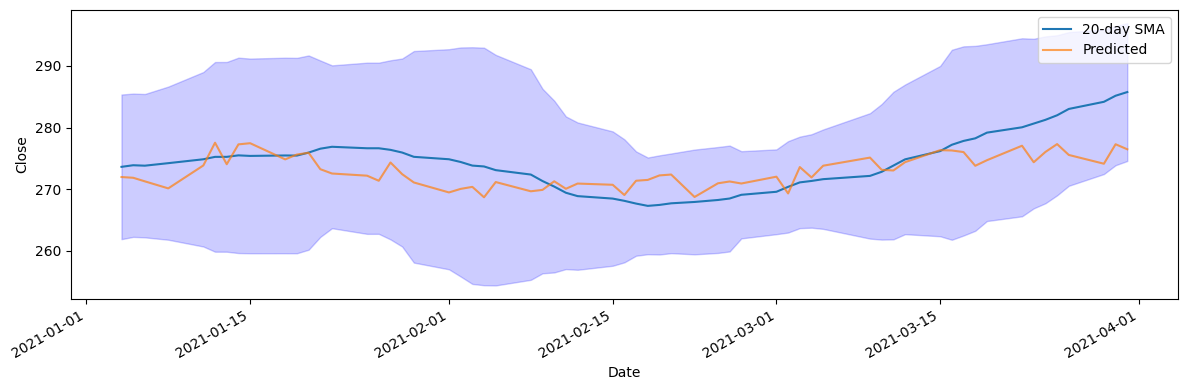

In [30]:
time_period = 20
rolling_mean = y.rolling(window=time_period).mean().loc[y_test.index]
rolling_std = y.rolling(window=time_period).std().loc[y_test.index]

ax = rolling_mean.plot(label='20-day SMA', figsize=(12, 4))
upper_band = (rolling_mean + (rolling_std * 2)).rename('Upper Band')
lower_band = (rolling_mean - (rolling_std * 2)).rename('Lower Band')

pred_mean.plot(ax=ax, label='Predicted', alpha=.7)

ax.fill_between(y_test.index,
                lower_band,
                upper_band,
                color='b', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()

Bollinger Band seem not useful since all predicted values are within the band.

Thus, use 20-day SMA to determine trading decision as follows:
* if the predicted price is lower than the SMA —> buy
* if the predicted price is higher than the SMA —> sell
* if within the Bollinger band, hold.

In [31]:
from datetime import timedelta
import numpy as np

daily_trading_dates = y_test.index # Trade every 1 trading day
weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days

#### 6. Evaluate results of the training decisions based on the predictions

In [32]:
results_df = pd.concat([y_test, rolling_mean.rename('20-day SMA'), pred_mean.rename('Predicted')], axis=1)
results_df

,Price,20-day SMA,Predicted
Date,,,
2021-01-04,272.00,273.6285,271.975773
2021-01-05,275.20,273.8885,271.859874
2021-01-06,272.93,273.8170,271.278074
2021-01-08,283.64,274.2245,270.139706
2021-01-11,289.49,274.8545,273.853073
...,...,...,...
2021-03-25,286.66,281.9810,277.314277
2021-03-26,291.22,283.0065,275.554953
2021-03-29,293.30,284.1630,274.133572


Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Predicted (Price)'.

In [33]:
results_dfs = get_trading_decision_and_results(
    daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
    results_df, benchmark_col='20-day SMA', compare_against_col='Predicted',
    initial_balance=0, initial_no_stock=0, max_no_stock_to_trade=1
)
    
capital_returns = 0
for interval, df in results_dfs.items():
    capital_return = df.iloc[-1]['Balance']
    capital_returns += capital_return
    print(f"{interval} capital return: {round(capital_return, 4)}")
print(f"Capital return in total: {round(capital_returns, 4)}")

Daily capital return: 275.77
Weekly capital return: -14.3
Monthly capital return: 0
Capital return in total: 261.47


Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Price'.

In [34]:
results_dfs = get_trading_decision_and_results(
    daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
    results_df, benchmark_col='20-day SMA', compare_against_col='Price',
    initial_balance=0, initial_no_stock=0, max_no_stock_to_trade=1
)
    
capital_returns = 0
for interval, df in results_dfs.items():
    capital_return = df.iloc[-1]['Balance']
    capital_returns += capital_return
    print(f"{interval} capital return: {round(capital_return, 4)}")
print(f"Capital return in total: {round(capital_returns, 4)}")

Daily capital return: 127.06
Weekly capital return: 35.34
Monthly capital return: 11.92
Capital return in total: 174.32


# Create a function containing all the processes from the 2. EDA part until this part, excluding the visualization parts. Then, iterate through data_dfs and apply the function to each dataframe to get the capital return for each stock.
first_df = data_dfs[full_sheet_names[0]]

In [35]:
# Downsampling and aggregating by taking the mean of each hour
collapsed_data = df.resample('H').mean()

# Downsampling and aggregating by taking the sum of each day
collapsed_data = df.resample('D').sum()

# Downsampling and aggregating by taking the maximum value of each month
collapsed_data = df.resample('M').max()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8956\1291649519.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  collapsed_data = df.resample('H').mean()
C:\Users\Admin\AppData\Local\Temp\ipykernel_8956\1291649519.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  collapsed_data = df.resample('D').sum()


### <b>5. Train a model</b>

* for nan values, you could consider discarding them if you have enough data.
Or you could plot the data to see how the nan values can be filled (e.g. average, ffill, bfill, etc.). It could be hard to figure this out, so it such cases, could just drop the nan values becausing imputing can bring bias that might not be helpful to the model/predictions.

if the predicted price is lower than the lowerbound =>  buy
if the predicted price is within the Bollinger band => hold
if the predicted price is higher than the upperbound— => sell

1 train a model and predict on a daily, weekly and monthly basis.

2 calculate threshold/uncertainty (of the prediction) (+ bollinger band of the observed data?)<br>
Typical values used:<br>
Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)<br>
Medium term: 20 day moving average, bands at 2 standard deviations.<br>
Long term: 50 day moving average, bands at 2.5 standard deviations.<br>
                                                       
3 decide to buy/hold/sell based on the threshold

4 store the value/profit if I had traded based on the decision. (also need to define how many money/stock I already have.)

SARIMAX is a powerful tool for modeling and forecasting time series data, especially when there are known seasonal patterns and the influence of exogenous variables needs to be considered.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous variables allows for the incorporation of additional factors that may influence the time series.

The SARIMAX model is typically denoted as SARIMAX(p, d, q)(P, D, Q, s), where:

p, d, and q are the orders of the non-seasonal AR, differencing, and MA components, respectively.
P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
Exogenous variables can be included in the model by specifying them separately.

The SARIMAX model assumes that the time series is stationary after differencing. It models the relationship between the observations and the lags of the observations (autoregressive terms), the differences between observations (differencing terms), and the errors (moving average terms), both in the non-seasonal and seasonal components.

p is the number of autoregressive terms
d is the number of non-seasonal differences needed for stationarity
q is the number of lagged forecast errors in the prediction equation

ARIMA. it just takes the past values of the stock market.

=> move on to SARIMA. S stands for seasonality.

=> SARIMAX - also takes into account external features (i.e, other features)
SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with eXogenus factors’

=> primarily they are used for understanding the patterns or features of the time series data but we can use them for predictions.

facebook's PROPHET. easy to understand. conceptually similar to SARIMAX.

Uber's timeseries prediction model.


https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

19:57:43 - cmdstanpy - INFO - Chain [1] start processing
19:57:43 - cmdstanpy - INFO - Chain [1] done processing


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


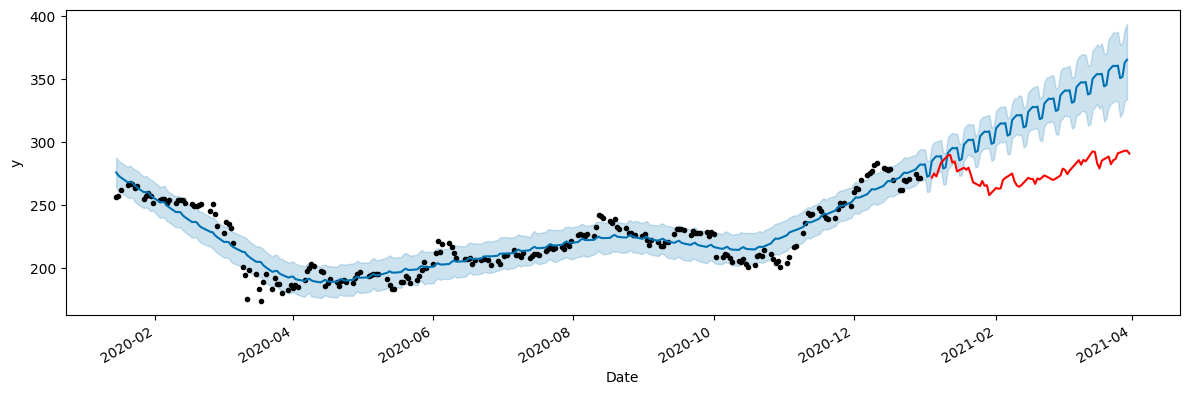

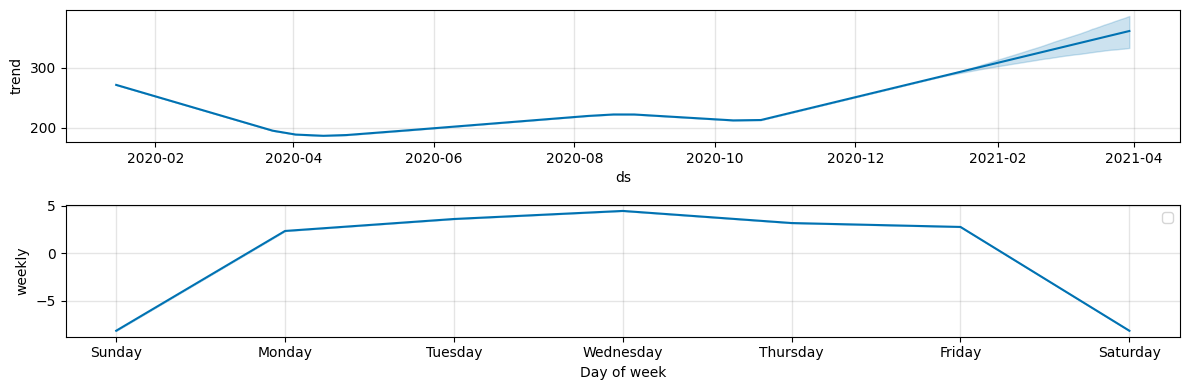

In [36]:
from prophet import Prophet
m = Prophet()
m.fit(pd.concat([X_train, y_train], axis=1).reset_index().rename(columns={'Date': 'ds', 'Price': 'y'}))

# Forecast for the next 3 months
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
# print(forecast.tail())

m.plot(forecast, figsize=(12, 4))
y_test.plot(label='Price', color='red')
m.plot_components(forecast, figsize=(12, 4))
plt.legend();

3. set evaluation metrics
(e.g., Since stock prices prediction is essentially a regression problem,
 the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %)
 will be our current model evaluation metrics. Both are useful measures of forecast accuracy. )


4. build a prediction model
* When predicting short-term stock prices, it is generally better to focus on more recent data rather than using the data from the entire year. However, it's important to strike a balance between using recent data and having enough historical context. It's recommended to experiment with different time periods and evaluate the performance of your predictions to find the optimal balance.

* LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series.
    It can capture historical trend patterns, and predict future values with high accuracy. 
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571
=> can be difficult/time-consuming to understand. can be tried out after trying simpler models.

* Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects.
On top of that, it adds the X: external variables. If you have any variables that could help your model to improve,
you could add them with SARIMAX.

* exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
es = SimpleExpSmoothing(co2_data.co2.values)
es.fit(smoothing_level=0.01)
plt.plot(co2_data.co2.values)
plt.plot(es.predict(es.params, start=0, end=None))
plt.show()
=> takes in only 1 column

* Reinforcement learning
https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/


5. evaluate model performance
=> create bollinger bands using the prediced price and recommend buy, hold, or sell decisions?


6. based on the final model prediction, recommend BUY, HOLD, SELL decisions for each stock.
(Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.)


7. evaluate on the basis of capital returns (based on the trading decisions).
how to quantify or calculate the returns when we don't know how many stocks we had and when we bought them?


8. use bollinger bands to measure the system/model's effectiveness??

Candlestick charts are used by traders to determine possible price movement based on past patterns. Candlesticks are useful when trading as they show four price points (open, close, high, and low) throughout the period of time the trader specifies.

In [37]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Candlestick(
#     x=train_df_1.index,
#     open=train_df_1['Open'],
#     high=train_df_1['High'],
#     low=train_df_1['Low'],
#     close=train_df_1['Close']
#     )
#     ])

# # fig.update_layout(
# #     margin=dict(l=30, r=30, t=10, b=10),
# #     # paper_bgcolor='LightSteelBlue',
# # )

# fig.update_layout(
#     title=f'{stock_name_1}: Daily OHLC', 
#     yaxis_title='Price (USD)',
#     width=900,
#     height=600)

# fig.show()

In [38]:
# # Candlestick Chart and Volume Separately
# # Source: https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

# from plotly.subplots import make_subplots

# # figure with secondary y-axis
# fig = make_subplots(specs=[[{'secondary_y': True}]])

# # candlestick
# fig.add_trace(
#     go.Candlestick(
#         x=train_df_1.index,
#         open=train_df_1.Open,
#         high=train_df_1.High,
#         low=train_df_1.Low,
#         close=train_df_1.Close,
#         showlegend=False),
#     row=1,
#     col=1,
#     secondary_y=True
# )

# # volume
# fig.add_trace(
#     go.Bar(x=train_df_1.index,
#            y=train_df_1['Vol.'],
#            showlegend=False,
#            marker={
#                'color': 'grey',
#            }),
#     secondary_y=False,
# )

# fig.update_layout(title=f'{stock_name_1}: Daily OHLCV',
#                   yaxis_title='Price (USD)',
#                   width=900,
#                   height=600)

# fig.show()

if the target is short-term decision, 

bullish patterns -> price likely to rise => buy
bearish patterns -> price likely to fall => sell

If a candlestick pattern doesn’t indicate a change in market direction, it is what is known as a continuation pattern. These can help traders to identify a period of rest in the market, when there is market indecision or neutral price movement. => hold

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

From Semih:

Typically bollinger bands are used to make buy and sell decisions if the predicted price is lower than the lowerbound—> buy if the predicted price is higher than the upperbound—> sell

My interpretation is (the way I would approach) we can use bollinger bands to label the data. Afterwards a classifier or a recommendation system could be developed to predict buy and sell decisions. Based on the recommended actions a loss or profit could be calculated. I don’t think there is only one approach but this is how I would approach it.